## 10.2 케라스로 다층 퍼셉트론 구현하기
* Keras
    + 모든 종류의 신경망을 손쉽게 만들고 훈련, 평가, 실행할 수 있는 고수준 딥러닝 API
    + 2015년 3월 오픈소스 공개
    + Keras-team : 3개의 딥러닝 라이브러리 Tensorflow, CNTK, Theano 중 백엔드 선택 가능, 2016년 후반부터 Apache MXNet, Apple's CoreML, Javascript or timescript, PlaidML에서도 실행 가능
    + Tensorflow의 tf.keras : Tensorflow에 번들 형태로 포함. Tensorflow 2.0 이후부터는 사실상 모두 Keras 통해 동작. 

### 10.2.1 텐서플로 2 설치
* Jupiter Notebook 설치 전제 하에, **Anaconda Prompt 관리자 권한 실행** 후 아래 코드 실행함. 
```
    python -m pip install --upgrade pip
    pip install tensorflow
```
* 제대로 설치되었다면 아래 코드가 정상 동작할 것이고 그렇지 않으면 traceback 내용 확인하여 대응 필요. 
    + *Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found* 메시지 발생하여, CUDA Toolkit 다운로드 후 설치 진행하였음...

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.10.0'

In [ ]:
keras.__version__

'2.10.0'

### 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기
* Fashion MNIST : MNIST와 형태가 정확히 같지만 손글씨 숫자가 아니라 패션 아이템을 나타내는 이미지 데이터셋
    + 10개 class, 28&times;28 픽셀 크기의 70000개 흑백 이미지
    + 샘플이 더 다양하여 MNIST 보다 분류하기 어려움. 간단한 선형모형 기준 MNIST는 92% 정확도, Fashion MNIST는 83% 정확도 달성.

#### 케라스를 사용하여 데이터셋 적재하기
* Keras는 널리 사용되는 데이터셋을 다운로드 할 수 있는 함수 제공
* Keras를 통해 다운로드 하는 경우 28&times;28 크기의 배열이며 픽셀 강도가 정수(0-255)로 표현됨
    + 0-1 범위로 조정하기 위해 일괄 255로 나누는 작업 필요

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
# training set 크기 및 데이터 타입 확인
X_train_full.shape

(60000, 28, 28)

In [ ]:
X_train_full.dtype

dtype('uint8')

In [ ]:
# Validation set 생성 및 scaling
# train:validation:test = 55000:5000:10000
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [ ]:
# Class 이름 리스트 만들기
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Coat'

#### 시퀀셜 API를 사용하여 모델 만들기
* 두 개의 은닉층(hidden layer)으로 이루어진 분류용 다층 퍼셉트론(MLP)
    + Sequential API : Keras의 가장 간단한 신경망 모델. 순서대로 연결된 층을 일렬로 쌓아서 구성.
    + Flatten layer : 입력 이미지를 1D 배열로 변환. 입력 데이터 X를 받아 <kbd>X.reshape(-1, 28*28)</kbd> 계산
        - <kbd>input_shape</kbd> 지정 필요. 배치 크기 제외하고 샘플의 크기만 작성
    + Dense hidden layer1 : 300개 뉴런으로 구성. activation function으로 ReLU 사용. 모든 연결 가중치(가중치 행렬(W)과 편향 벡터(b)) 포함. 
    + Dense hidden layer2 : Hidden layer1과 동일하며 100개 뉴런으로 구성
    + Dense output layer : 각 클래스 별로 하나씩, 10개의 뉴런으로 구성. softmax activation function 사용.

In [ ]:
model = keras.models.Sequential(name="fashion_mnist_model")
model.add(keras.layers.Flatten(name="Flat", input_shape=[28, 28]))
model.add(keras.layers.Dense(300, name="Hidden1", activation="relu"))
model.add(keras.layers.Dense(100, name="Hidden2", activation="relu"))
model.add(keras.layers.Dense(10, name="Output", activation="softmax"))

"""
또는 Sequential model 안에 layer 정보를 모두 작성할 수도 있음
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.Dense(300, activation="relu"),
 keras.layers.Dense(100, activation="relu"),
 keras.layers.Dense(10, activation="softmax")
])
"""

'\n또는 Sequential model 안에 layer 정보를 모두 작성할 수도 있음\nmodel = keras.models.Sequential([\n keras.layers.Flatten(input_shape=[28, 28]),\n keras.layers.Dense(300, activation="relu"),\n keras.layers.Dense(100, activation="relu"),\n keras.layers.Dense(10, activation="softmax")\n])\n'

* <kbd>summary()</kbd> method는 모델의 모든 층을 출력함
    + 각 층의 이름 (<kbd>name=</kbd> parameter로 지정 가능)
    + 각 층의 출력 크기
    + 각 층의 parameter 개수
    + 훈련 가능한 / 불가능한 총 parameter 개수
* Dense layer는 보통 많은 parameter가 존재
    + 784&times;300+300=235500
    + 300&times;100+10=30100
    + 100&times;10+10=1010
    + 훈련 데이터를 학습하기에 충분한 유연성을 가짐 + 과대적합(overfitting) 가능성

In [ ]:
model.summary()

Model: "fashion_mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flat (Flatten)              (None, 784)               0         
                                                                 
 Hidden1 (Dense)             (None, 300)               235500    
                                                                 
 Hidden2 (Dense)             (None, 100)               30100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model layer 정보를 list로 출력
model.layers

In [ ]:
# layer의 index나 이름으로 선택 가능
hidden1A = model.layers[1]
hidden1A.name

'Hidden1'

In [ ]:
model.get_layer('Hidden1') is hidden1A

True

* Dense layer는 연결 가중치를 무작위로 초기화 하며, 편향은 0으로 초기화 함
    + Sequential Model 정의할 때 <kbd>input_shape</kbd>를 지정하였기 때문에 가능
    + 만약 지정하지 않아도 문제는 없으나, build하기 전까지 <kbd>summary()</kbd> method 등의 특정 작업 수행 불가능함 

In [ ]:
# 모든 layer의 parameter는 get_weights() 또는 set_weights() method를 통해 접근 가능
weights, biases = hidden1A.get_weights()
print(weights)
print(weights.shape)

[[-0.0662602  -0.00408696 -0.02201564 ... -0.07398505 -0.05954855
  -0.06847581]
 [-0.01266389  0.04986744 -0.03145026 ... -0.03530715  0.05876213
  -0.03890733]
 [ 0.02631707 -0.00368525 -0.04902753 ...  0.06258279  0.0045879
   0.008622  ]
 ...
 [ 0.00251871  0.07394257  0.01182427 ... -0.03306888  0.07268916
  -0.04292552]
 [-0.06215855 -0.06769737 -0.02940455 ...  0.03895978  0.06329028
  -0.008534  ]
 [ 0.06944744  0.02753511 -0.02010798 ... -0.030647   -0.05967209
   0.05856867]]
(784, 300)


In [ ]:
print(biases)
print(biases.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(300,)


#### 모델 컴파일
* <kbd>compile()</kbd> method를 호출하여 loss function, optimizer, metric을 지정할 수 있음.
    + sparse_categorical_crossentropy : sparse label을 가지고 있는 경우 사용.
        - 마약 one-hot vector label이라면 <kbd>categorical_corssentropy</kbd> 사용
        - 이진 분류의 경우, output layer에서 sigmoid activation function + binary_crossentropy loss function 사용
    + sgd : 확률적 경사 하강법(stochastic gradient descent) 기반의 모델 훈련 = 역전파 알고리즘의 가중치 조정 단계
        - learning rate을 조절할 경우 "sgd" 대신 <kbd>keras.optimizers.SGD(learning_rate=0.01)</kbd>을 사용함.
    + accuracy : classification model 이니까,,


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

#### 모델 훈련과 평가
* <kbd>fit()</kbd> method를 통한 훈련
    + 입력 특성(X_train), 타겟 클래스(y_train), 에포크 횟수, 검증 세트
    + 훈련 세트 선능이 검증 세트보다 월등히 높다면 overfitting 또는 버그 존재 가능
    + 현재 결과에서는 overfitting 문제는 없는 것으로 판단됨. (0.9191, 0.8974)
* loss/accuracy 계산에 weight 부여하기
    + class_weight : 클래스 별로 샘플의 수가 달라서, 적게 등장하는 클래스에 높은 가중치를 부여하는 등의 목적으로 사용
    + sample_weight : 전문가에 의해 label이 부여된 샘플과 crowdsourcing label 부여된 샘플이 함께 존재하는 경우, 전자에 높은 가중치를 부여하는 등의 목적으로 사용 


In [ ]:

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))
"""
# validation set을 나누지 않고 validation_split= parameter 사용 가능
history = model.fit(X_train_full, y_train_full, epochs=30,
                    validation_split=0.2)
"""

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7000 - accuracy: 0.7720 - val_loss: 0.4946 - val_accuracy: 0.8332
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4837 - accuracy: 0.8331 - val_loss: 0.4678 - val_accuracy: 0.8396
Epoch 3/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4396 - accuracy: 0.8471 - val_loss: 0.4089 - val_accuracy: 0.8608
Epoch 4/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4137 - accuracy: 0.8559 - val_loss: 0.4111 - val_accuracy: 0.8624
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3943 - accuracy: 0.8619 - val_loss: 0.4044 - val_accuracy: 0.8630
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3790 - accuracy: 0.8677 - val_loss: 0.3852 - val_accuracy: 0.8700
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3647 - accuracy: 0.8722 - val_loss: 0.3675 - val_accuracy:

'\n# validation set을 나누지 않고 validation_split= parameter 사용 가능\nhistory = model.fit(X_train_full, y_train_full, epochs=30,\n                    validation_split=0.2)\n'

* <kbd>fit()</kbd> method output
    + .params : 훈련 파라미터
    + .epoch : 수행된 epoch list
    + .history : loss와 accuracy를 담은 dictionary. learning curve 그리는 데에 사용 가능

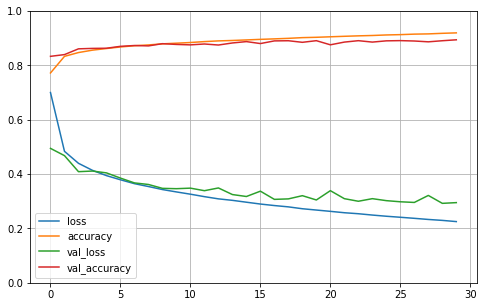

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

* learning curve
    + training loss는 epoch 진행 중에, valid loss는 epoch 끝난 후에 계산되므로, training curve는 epoch의 절반만큼 왼쪽으로 이동되었다고 고려하는 것이 바라직함.
    + 일반적으로는 충분히 오래 훈련하면 훈련세트 성능이 검증세트의 성능을 앞지르는 것이 정상적임.
    + valid loss가 계속 감소한다면 훈련이 추가로 더 필요한 것으로 판단할 수 있음.
* test set을 사용한 일반화 오차 추정
    + <kbd>evaluate()</kbd> method 사용
    + hyperparameter tuning에 test set은 사용되지 않으므로 성능이 조금 낮은 것이 일반적임

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3294 - accuracy: 0.8847


[0.3293896019458771, 0.8847000002861023]

#### 모델을 사용해 예측을 만들기
* <kbd>predict()</kbd> method 사용
    + 각 class에 대해 확률을 추정함
    + 가장 높은 확률을 가진 class 정보만 알고싶다면 <kbd>predict_classes()</kbd> method 사용 : **Tensorflow 2.6 이후 제거됨!**

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 88ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.94],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [ ]:
# y_pred = model.predict_classes(X_new)
y_pred = y_proba.argmax(axis=1)
y_pred

array([9, 2, 1], dtype=int64)

In [ ]:

import numpy as np
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:

# 실제 class와 비교
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)